# Analyzing the Effect of Hiking Trails and National Wilderness Areas on Missoula County Montana Parcel Value

### Outside of this notebook, I have downloaded these spatial datasets: US States, Missoula County Parcels, Montana Hiking Trails, and National Wilderness Areas. I added those to my local Postgis Database and then I began processing and analyzing those datasets using geopandas.

In [48]:
# Import libraries
import geopandas as gpd
import matplotlib.pyplot as plt
import psycopg2
import os
from dotenv import load_dotenv
import warnings
warnings.filterwarnings("ignore")

In [49]:
# Connect to postgis database, read in tables as geopandas geodataframes
load_dotenv()

conn = psycopg2.connect(dbname="spatial_db", user=os.getenv('DB_USERNAME'), password=os.getenv('DB_PASSWORD'), host="localhost", port="5432")

states_query = 'SELECT * FROM "States";'
parcels_query = 'SELECT * FROM "Missoula_Parcels";'
nwa_query = 'SELECT * FROM "National_Wilderness_Areas";'
trails_query = 'SELECT * FROM "Trails";'

states_gdf = gpd.read_postgis(states_query, conn, geom_col="geom")
parcels_gdf = gpd.read_postgis(parcels_query, conn, geom_col="geom")
nwa_gdf = gpd.read_postgis(nwa_query, conn, geom_col="geom")
trails_gdf = gpd.read_postgis(trails_query, conn, geom_col="geom")

conn.close()

In [50]:
# Select Montana from States GDF, set all GDF to EPSG 6514, subset nwa_gdf to only Montana
montana_gdf = states_gdf[states_gdf["state"] == 'MT']
montana_gdf = montana_gdf.to_crs(epsg=6514)
trails_gdf = trails_gdf.to_crs(epsg=6514)
nwa_gdf = nwa_gdf.to_crs(epsg=6514)
nwa_montana_gdf = gpd.overlay(nwa_gdf, montana_gdf, how="intersection")

### After aligning the coordinate systems of each dataset and clipping some features, I like to validate with a map using Matplotlib to make sure all features are aligned.

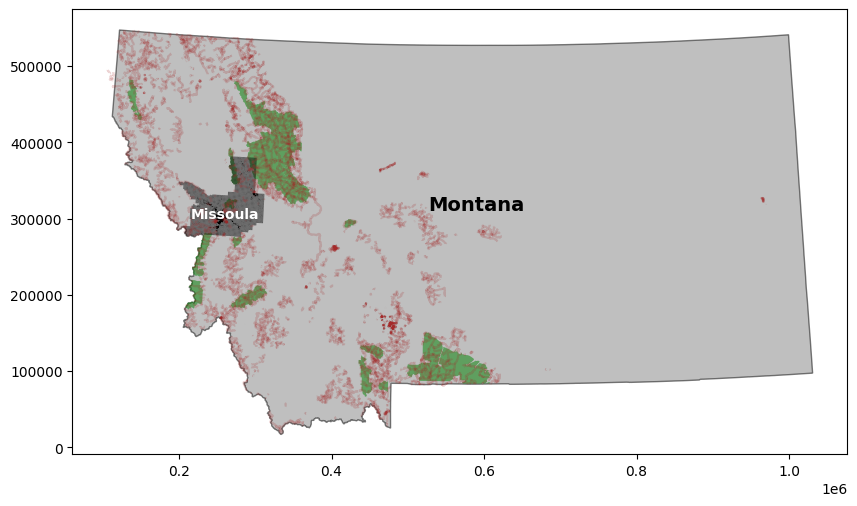

In [51]:
# Map montana_gdf, trails_gdf, and parcels_gdf to validate CRS
fig, ax = plt.subplots(figsize=(10, 10))

montana_gdf.plot(ax=ax, color='gray', edgecolor='black', alpha=0.5)
montana_gdf.apply(
    lambda x: ax.annotate(
        text=x['name'], 
        xy=x.geom.centroid.coords[0], 
        ha='center',
        weight='bold',
        fontsize=14
    ), 
    axis=1
)

ax.annotate('Missoula', (260000, 300000), color='white', ha='center', weight='bold')

nwa_montana_gdf.plot(ax=ax, color='green', alpha=0.5)
trails_gdf.plot(ax=ax, color='brown', alpha=0.2)
parcels_gdf.plot(ax=ax, color='black', alpha=0.5)

plt.show()

### Now I want to focus in on Missoula County. You can see some transformations below, and I plot another map to validate everything.

In [52]:
# Select only NWA polygons and trails intersecting Missoula county, dissolve NWA to fix cuts
trails_missoula_gdf = gpd.overlay(trails_gdf, parcels_gdf, how="intersection")
trails_missoula_gdf = trails_missoula_gdf.reset_index(drop=True)

nwa_missoula_cuts_gdf = gpd.overlay(nwa_gdf, parcels_gdf, how="intersection")
nwa_missoula_cuts_gdf = nwa_missoula_cuts_gdf.reset_index(drop=True)

nwa_missoula_gdf = nwa_missoula_cuts_gdf.dissolve(by="WILDERNESSNAME")
nwa_missoula_gdf = nwa_missoula_gdf.reset_index()

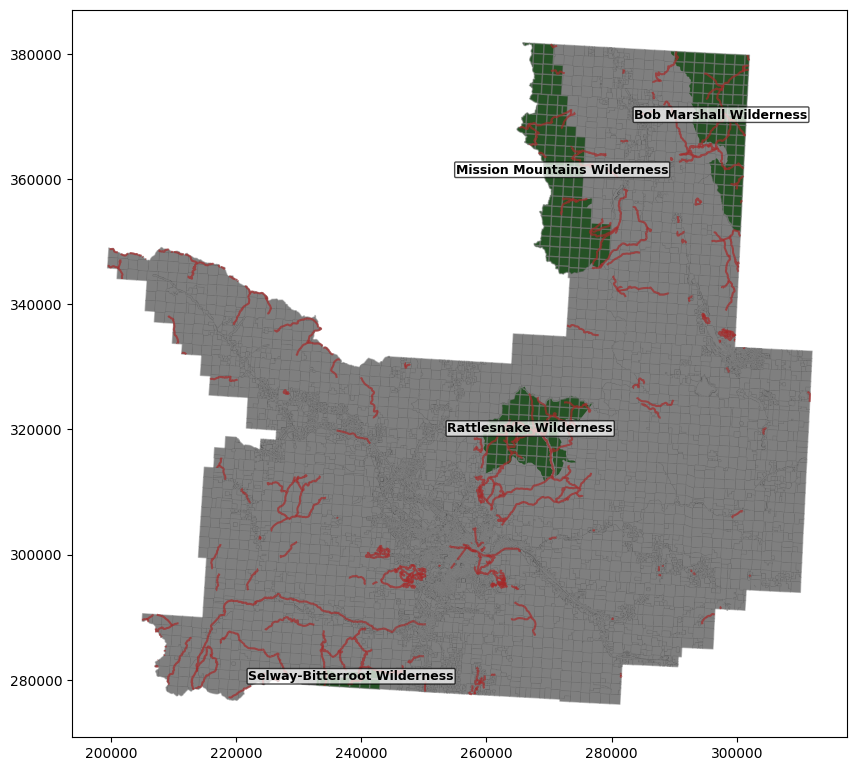

In [53]:
# Plot newly subsetted data
fig, ax = plt.subplots(figsize=(10, 10))

nwa_missoula_gdf.plot(ax=ax, color='green', alpha=0.7)
nwa_missoula_gdf.apply(
    lambda x: ax.annotate(
        text=x['WILDERNESSNAME'], 
        xy=x.geometry.centroid.coords[0], 
        ha='center',
        weight='bold',
        fontsize=9,
        bbox=dict(facecolor='white', alpha=0.7, boxstyle="round,pad=0.1")
    ), 
    axis=1
)

trails_missoula_gdf.plot(ax=ax, color='brown', alpha=0.7)
parcels_gdf.plot(ax=ax, color='black', edgecolor='gray', alpha=0.5)

plt.show()

### Now I am going to start performing some spatial joins on the parcel dataset and generate three subsets of parcels. The following maps show the resulting subset parcels in black.

In [54]:
# Make parcel subsets: parcels that intersect trails, NWA, and both
parcels_trails_gdf = gpd.sjoin(parcels_gdf, trails_missoula_gdf, how="inner", predicate="intersects", lsuffix="_left", rsuffix="_right")
parcels_trails_gdf = parcels_trails_gdf.reset_index()

parcels_nwa_gdf = gpd.sjoin(parcels_gdf, nwa_missoula_gdf, how="inner", predicate="intersects", lsuffix="_left", rsuffix="_right")
parcels_nwa_gdf = parcels_nwa_gdf.reset_index()

parcels_trails_nwa_gdf = gpd.sjoin(parcels_nwa_gdf, trails_missoula_gdf, predicate="intersects")
parcels_trails_nwa_gdf = parcels_trails_nwa_gdf.reset_index()

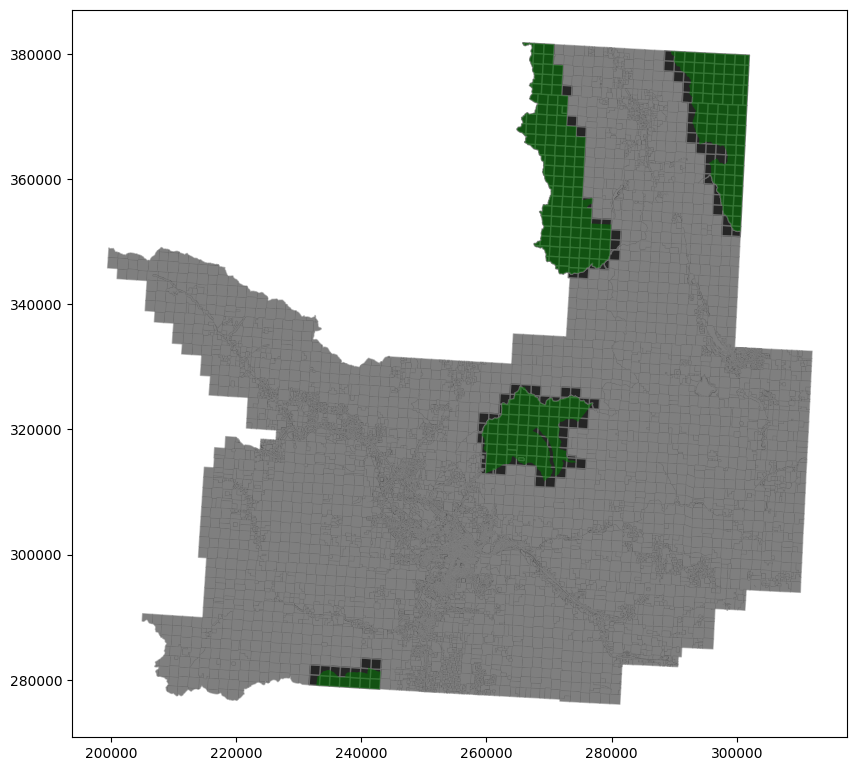

In [55]:
# Plot subsetted NWA parcels
fig, ax = plt.subplots(figsize=(10, 10))

parcels_nwa_gdf.plot(ax=ax, color='black', edgecolor='gray', alpha=0.7)
parcels_gdf.plot(ax=ax, color='black', edgecolor='gray', alpha=0.5)
nwa_missoula_gdf.plot(ax=ax, color='green', alpha=0.5)

plt.show()

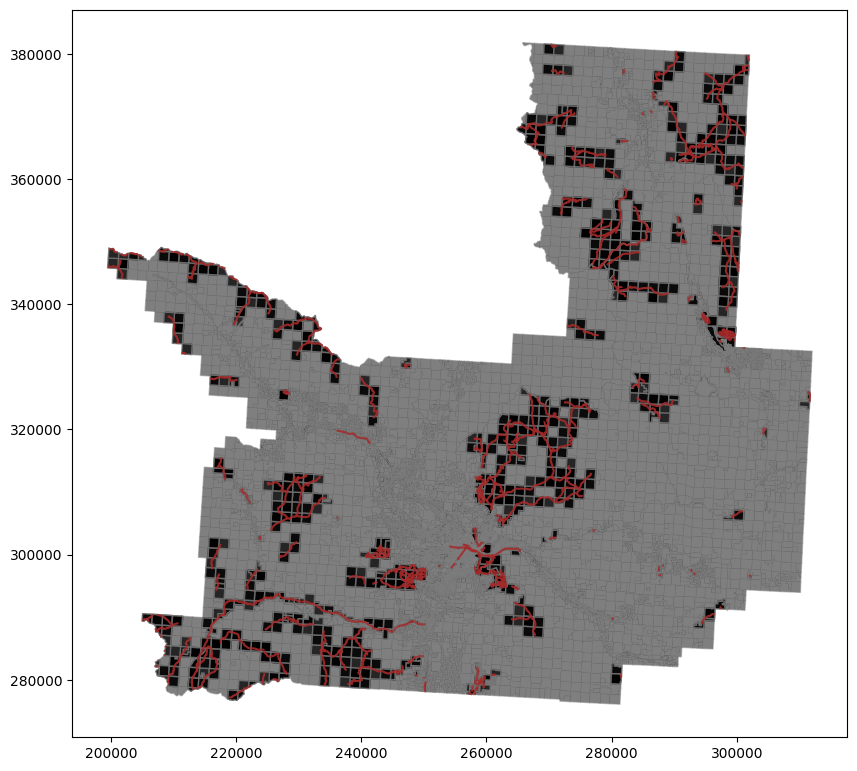

In [56]:
# Plot subsetted trail parcels
fig, ax = plt.subplots(figsize=(10, 10))

parcels_trails_gdf.plot(ax=ax, color='black', edgecolor='gray', alpha=0.7)
parcels_gdf.plot(ax=ax, color='black', edgecolor='gray', alpha=0.5)
trails_missoula_gdf.plot(ax=ax, color='brown', alpha=0.9)

plt.show()

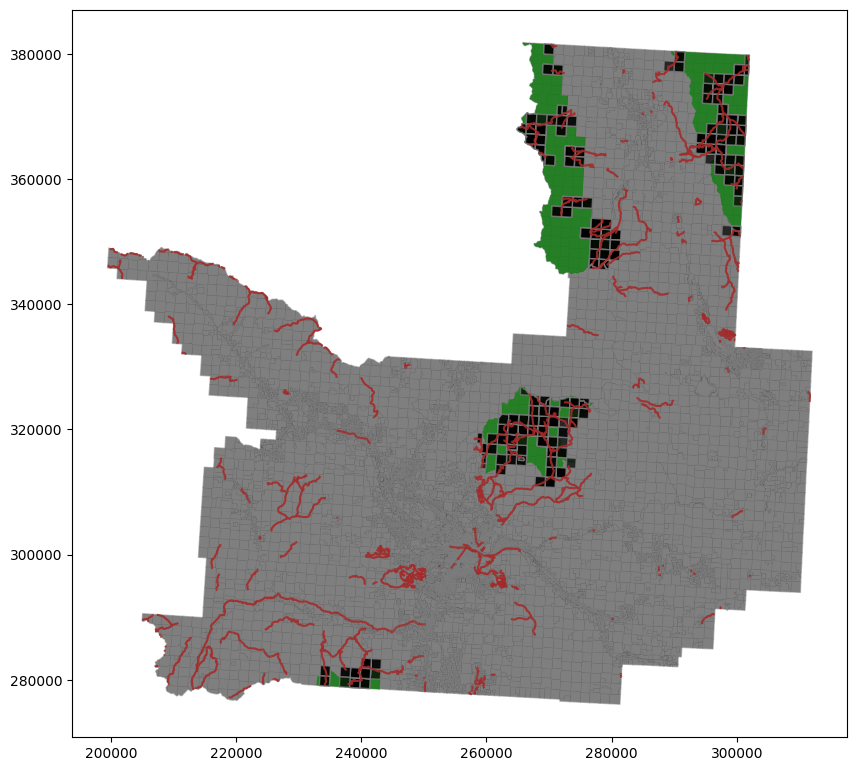

In [57]:
# Plot subsetted trail/NWA parcels
fig, ax = plt.subplots(figsize=(10, 10))

parcels_gdf.plot(ax=ax, color='black', edgecolor='gray', alpha=0.5)
trails_missoula_gdf.plot(ax=ax, color='brown', alpha=0.9)
nwa_missoula_gdf.plot(ax=ax, color='green', alpha=0.7)
parcels_trails_nwa_gdf.plot(ax=ax, color='black', edgecolor='gray', alpha=0.7)

plt.show()

### Finally, we can take the average total value the parcel dataset and each subset. This generates a nice trend in value.

In [58]:
# Calculate average of totalvalue for each gdf
avg_parcels = parcels_gdf['totalvalue'].mean()
avg_parcels_trails = parcels_trails_gdf['totalvalue__right'].mean()
avg_parcels_nwa = parcels_nwa_gdf['totalvalue__right'].mean()
avg_parcels_trails_nwa = parcels_trails_nwa_gdf['totalvalue__right'].mean()

print(f"Average total value for all Missoula County parcels: ${avg_parcels:,.0f}")
print(f"Average total value for parcels intersected by trails: ${avg_parcels_trails:,.0f}")
print(f"Average total value for parcels intersected by National Wilderness Areas: ${avg_parcels_nwa:,.0f}")
print(f"Average total value for parcels intersected by both National Wilderness Areas and trails: ${avg_parcels_trails_nwa:,.0f}")

Average total value for all Missoula County parcels: $461,780
Average total value for parcels intersected by trails: $421,774
Average total value for parcels intersected by National Wilderness Areas: $368,971
Average total value for parcels intersected by both National Wilderness Areas and trails: $356,443


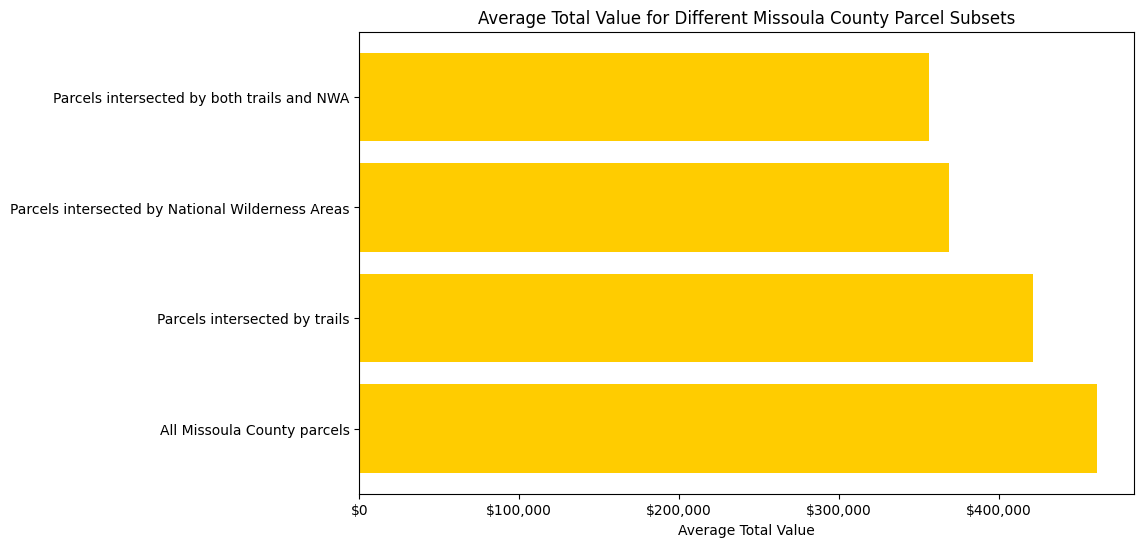

In [59]:
# Plot averages to visualize
categories = ['All Missoula County parcels', 
              'Parcels intersected by trails', 
              'Parcels intersected by National Wilderness Areas', 
              'Parcels intersected by both trails and NWA']
values = [
    avg_parcels, 
    avg_parcels_trails, 
    avg_parcels_nwa, 
    avg_parcels_trails_nwa
]

plt.figure(figsize=(10, 6))
plt.barh(categories, values, color=(1, 0.8, 0))

plt.xlabel('Average Total Value')
plt.title('Average Total Value for Different Missoula County Parcel Subsets')

plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'${x:,.0f}'))

plt.show()